In [1]:
pip install tf-models-official

Note: you may need to restart the kernel to use updated packages.


In [2]:
#@title Imports. {display-mode:'form'}
import pandas as pd
#from sklearn.metrics import confusion_matrix
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,GlobalAveragePooling2D,Flatten,concatenate,BatchNormalization, Dropout
from tensorflow.keras.applications import InceptionV3,DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import official.nlp.modeling.layers as nlp_layers
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
# Visualize the Train/Val loss
import matplotlib.pyplot as plt
%matplotlib inline

2023-08-25 01:49:12.379706: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-25 01:49:12.391132: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-25 01:49:12.558672: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-25 01:49:12.560425: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 01:49:14.026685: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, 109, 91)
else:
    input_shape = (109, 91, 3)

In [4]:
#@title Set the data generators. {display-mode:'form', run: "auto"}
#@markdown Data augmentation choices. Cell runs automatically if anything is changed.
shear_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
zoom_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
width_shift_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
height_shift_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
rotation_range = 10 #@param {type:"slider", min:0, max:90, step:5}
horizontal_flip = True #@param {type:"boolean"}
vertical_flip = True #@param {type:"boolean"}
#@markdown Data source (No need to change if the download succeeded.)
train_directory = 'training_set/' #@param ['z:/Data/Parkinson_DATScans UKE/full_ppmi_data/png/', '/content/drive/My Drive/MEVIS/Data/PPMI-classification/'] {allow-input: true}
val_directory = 'val_set/'
test_directory = '/home/notebooks/sundar/data_UNSMOOTH/PPMI-classification' 
base_path = '/home/notebooks/sundar'

train_datagen = ImageDataGenerator(rescale=1./255,
                                   
    shear_range=shear_range,
    zoom_range=zoom_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    rotation_range=rotation_range,
    horizontal_flip=horizontal_flip,
    vertical_flip=vertical_flip)

train_generator = train_datagen.flow_from_directory(os.path.join(base_path,'training_set'), # this is where you specify the path to the main data folder
                                                 target_size=(109,91),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='sparse',
                                                    seed = 42,
                                                 shuffle=True
                                                    )

val_generator = train_datagen.flow_from_directory(os.path.join(base_path,'val_set'), # this is where you specify the path to the main data folder
                                                 target_size=(109,91),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='sparse',
                                                  seed = 42,
                                                 shuffle=True
                                                    )

# Data Generator for validation without data augmentation!
test_datagen   = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(os.path.join(test_directory, 'all_2d_val'), # this is where you specify the path to the main data folder
                                                 target_size=(109,91),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='sparse',
                                                  seed = 42,
                                                 shuffle=True)

Found 904 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 186 images belonging to 2 classes.


In [5]:
batch_size = 32
input_dim = 1024
num_classes = 2
kernel_size = 3

In [6]:
#@title Set the Model {display-mode:'form', run: "auto"}
#@markdown Model architecture choices. Cell runs automatically if anything is changed.
#spectral_norm = True#@param {type:"boolean"}
# utilising functional API to build cnn layers
inputs = Input(shape=input_shape)
y = Conv2D(filters=64,kernel_size=kernel_size,activation='relu')(inputs)
y = Conv2D(filters=64,kernel_size=kernel_size,activation='relu')(y)
y = MaxPooling2D()(y)
y = Conv2D(filters=96, kernel_size=kernel_size, activation='relu')(y)
y = Conv2D(filters=96, kernel_size=kernel_size, activation='relu')(y)
y = MaxPooling2D()(y)
y = Conv2D(filters=128, kernel_size=kernel_size, activation='relu')(y)
y = Conv2D(filters=128, kernel_size=kernel_size, activation='relu')(y)
y = MaxPooling2D()(y)

# convert image to vector 
y = Flatten()(y)
#spectral normalisation

fc0 = tf.keras.layers.Dense(1024)
fcspect = nlp_layers.SpectralNormalization(fc0, norm_multiplier=0.9)(y)
y = Dropout(0.25)(fcspect)
y = tf.keras.layers.Dense(256, activation='relu')(y)
y = tf.keras.layers.Dropout(0.25)(y)
# else:
#   # dropout regularization
#   y = Dropout(0.25)(y)
#   y = tf.keras.layers.Dense(128, activation='relu')(y)
#   y = tf.keras.layers.Dropout(0.25)(y)
#fcspect = nlp_layers.SpectralNormalization(fc0, norm_multiplier=0.9)(fcspect)
#fcspect = nlp_layers.SpectralNormalization(fc0, norm_multiplier=0.9)(fcspect)
#output_layer1 = Dense(2 , activation='softmax')(fcspect)
# gp_layer = nlp_layers.RandomFeatureGaussianProcess(units=num_classes,
#                                                num_inducing=128,
#                                                normalize_input=False,
#                                                scale_random_features=True,
#                                                gp_cov_momentum=-1)
outputs = tf.keras.layers.Dense(2, activation="softmax")(y)
#outputs = (tf.keras.layers.Dense(units=1, activation='sigmoid'))(outputs)
#outputs = Dense(num_labels, activation='softmax')(y)
# model building by supplying inputs/outputs
model = Model(inputs=inputs, outputs=outputs)

2023-08-25 01:49:16.283390: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.keras.metrics.SparseCategoricalAccuracy(),
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)

In [13]:
model.compile(**train_config)

In [14]:
fit_config = dict(batch_size=128, epochs=100)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 109, 91, 3)]      0         
                                                                 
 conv2d (Conv2D)             (None, 107, 89, 64)       1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 105, 87, 64)       36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 52, 43, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 41, 96)        55392     
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 39, 96)        83040     
                                                             

In [16]:
history = model.fit(train_generator,
                    **fit_config,
                    verbose=1,
                    validation_data=(val_generator))

Epoch 1/100
15/15 [==============================] - 10s 580ms/step - loss: 0.2532 - sparse_categorical_accuracy: 0.8971 - val_loss: 0.1510 - val_sparse_categorical_accuracy: 0.9450
Epoch 2/100
15/15 [==============================] - 9s 572ms/step - loss: 0.2408 - sparse_categorical_accuracy: 0.9060 - val_loss: 0.1783 - val_sparse_categorical_accuracy: 0.9350
Epoch 3/100
15/15 [==============================] - 9s 577ms/step - loss: 0.2303 - sparse_categorical_accuracy: 0.9060 - val_loss: 0.1467 - val_sparse_categorical_accuracy: 0.9450
Epoch 4/100
15/15 [==============================] - 9s 581ms/step - loss: 0.2255 - sparse_categorical_accuracy: 0.9060 - val_loss: 0.1177 - val_sparse_categorical_accuracy: 0.9700
Epoch 5/100
15/15 [==============================] - 9s 604ms/step - loss: 0.2091 - sparse_categorical_accuracy: 0.9093 - val_loss: 0.1550 - val_sparse_categorical_accuracy: 0.9600
Epoch 6/100
15/15 [==============================] - 9s 585ms/step - loss: 0.2073 - sparse_cat

In [17]:
test_set = test_datagen.flow_from_directory(os.path.join(test_directory, 'all_2d_val'), # this is where you specify the path to the main data folder
                                                 target_size=(109,91),
                                                 color_mode='rgb',
                                                 batch_size=186,
                                                 seed = 42,
                                                 class_mode='sparse',
                                                 shuffle=True)

Found 186 images belonging to 2 classes.


In [18]:
y_train, y_test = next(test_set)

In [19]:
y_test.shape

(186,)

In [20]:
y_test

array([1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
       0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.],
      dtype=float32)

In [21]:
def predict_proba(X, model, num_samples):
    preds = [model(X, training=True) for _ in range(num_samples)]
    return np.stack(preds).mean(axis=0)
     
def predict_class(X, model, num_samples):
    proba_preds = predict_proba(X, model, num_samples)
    return np.argmax(proba_preds, axis=1)

In [22]:
def predict_with_dropout(data_generator, model, num_samples):
    y_preds = []
    for i in range(num_samples):
        batch_x = next(data_generator)
        y_pred = model(batch_x, training=True)  # Enable dropout
        y_preds.append(y_pred)
    y_preds = tf.stack(y_preds)  # Stack predictions along first axis
    y_mean = tf.reduce_mean(y_preds, axis=0)  # Compute mean prediction
    return y_mean

In [23]:
y_pred = predict_class(y_train, model, 100)
acc = np.mean(y_pred == y_test)
acc

0.9516129032258065

In [24]:
y_pred_proba = predict_proba(y_train, model, 100)


In [25]:
mc_pred_proba_array = np.round(y_pred_proba, 3)
mc_pred_proba_array

array([[0.004, 0.996],
       [0.083, 0.917],
       [0.014, 0.986],
       [0.01 , 0.99 ],
       [0.013, 0.987],
       [0.924, 0.076],
       [0.005, 0.995],
       [0.957, 0.043],
       [0.004, 0.996],
       [0.007, 0.993],
       [0.958, 0.042],
       [0.206, 0.794],
       [0.026, 0.974],
       [0.708, 0.292],
       [0.064, 0.936],
       [0.735, 0.265],
       [0.003, 0.997],
       [0.974, 0.026],
       [0.265, 0.735],
       [0.93 , 0.07 ],
       [0.   , 1.   ],
       [0.002, 0.998],
       [0.004, 0.996],
       [0.017, 0.983],
       [0.   , 1.   ],
       [0.962, 0.038],
       [0.019, 0.981],
       [0.141, 0.859],
       [0.98 , 0.02 ],
       [0.07 , 0.93 ],
       [0.138, 0.862],
       [0.005, 0.995],
       [0.928, 0.072],
       [0.006, 0.994],
       [0.779, 0.221],
       [0.007, 0.993],
       [0.   , 1.   ],
       [0.895, 0.105],
       [0.052, 0.948],
       [0.016, 0.984],
       [0.   , 1.   ],
       [0.967, 0.033],
       [0.889, 0.111],
       [0.9

In [26]:
#FOR TEST SET
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

n_samples = y_train.shape[0]
n_pixels = y_train.shape[1] * y_train.shape[2] * y_train.shape[3]
X = y_train.reshape(n_samples, n_pixels)

# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Fit PCA model
pca = PCA(n_components=2)
pca.fit(X_std)

# Transform data to principal components
X_pca = pca.transform(X_std)

In [27]:
# calculate entropy for each row
probs_array = np.array(mc_pred_proba_array)
entropy = -probs_array * np.log2(probs_array)
entropy = np.sum(entropy, axis=1)

# print the first 10 entropy values
print(entropy[:10])
entropy.shape

[0.03762237 0.41266263 0.1062737  0.08079311 0.10008209 0.38792562
 0.04541469 0.2558819  0.03762237 0.06017248]


/tmp/ipykernel_2067733/2257811129.py:3: RuntimeWarning: divide by zero encountered in log2
  entropy = -probs_array * np.log2(probs_array)
/tmp/ipykernel_2067733/2257811129.py:3: RuntimeWarning: invalid value encountered in multiply
  entropy = -probs_array * np.log2(probs_array)


(186,)

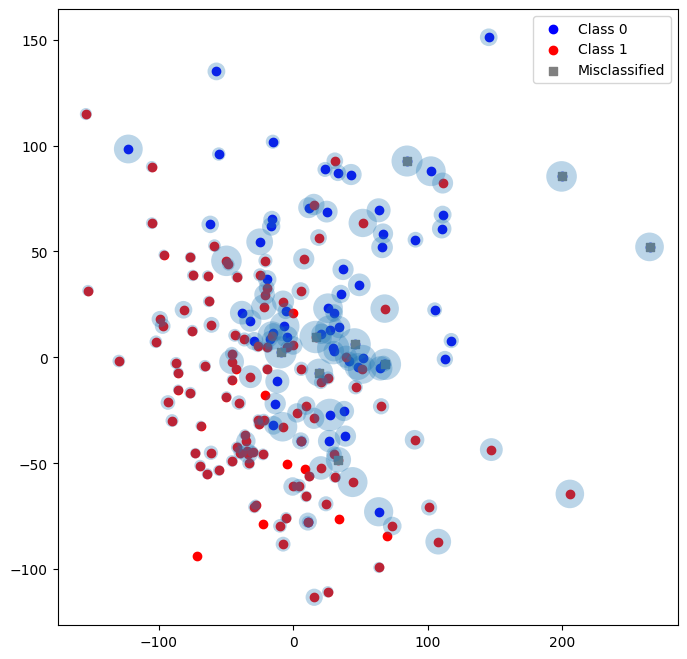

In [28]:
#@title Uncertainty Plot. {display-mode:'form', run: "auto"}
#@markdown Entropy, Predicted and True Value Plot

#@markdown Higher Entropy means higher uncertainty(INDICATED BY LARGER LIGHT BLUE MARKER AROUND THE POINTS)

transparency = 0.3 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
# from sklearn.decomposition import PCA
# Create x and y arrays from the PCA-transformed data
x = X_pca[:, 0]
y = X_pca[:, 1]

# Create arrays for uncertainty, predicted class, and true class
#uncertainty = ...  # shape (n_samples,)
#y_pred = ...  # shape (n_samples,)
colors = ['blue', 'red']  # Color for each class

# Create scatter plot
fig, ax = plt.subplots(figsize=(8, 8))
for c in range(2):
    mask = y_pred == c
    ax.scatter(x[mask], y[mask], c=colors[c], marker='o', label=f'Class {c}')
ax.scatter(x[y_test != y_pred], y[y_test != y_pred], c='gray', marker='s', label='Misclassified')
ax.legend()

# Add uncertainty as size of markers
sizes = 50 + 500 * entropy
ax.scatter(x, y, s=sizes, alpha=transparency, edgecolors='none')

plt.show()

In [29]:
# Assuming you have a 2D list called 'predictions' with shape (193, 2)
labels = []
for row in mc_pred_proba_array:
    if row[0] > row[1]:
        labels.append(0)
    else:
        labels.append(1)

In [30]:
y_pred = np.array(labels)
y_pred

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1])

In [31]:
y_test

array([1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
       0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.],
      dtype=float32)

In [32]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


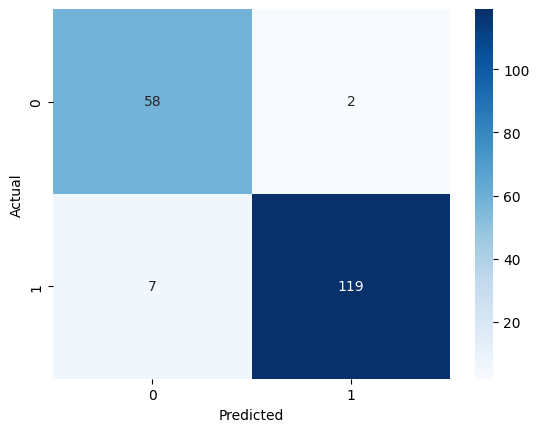

In [33]:
#import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



# Assuming you have a 1D array called 'predicted_labels' and a 1D array called 'actual_labels'
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

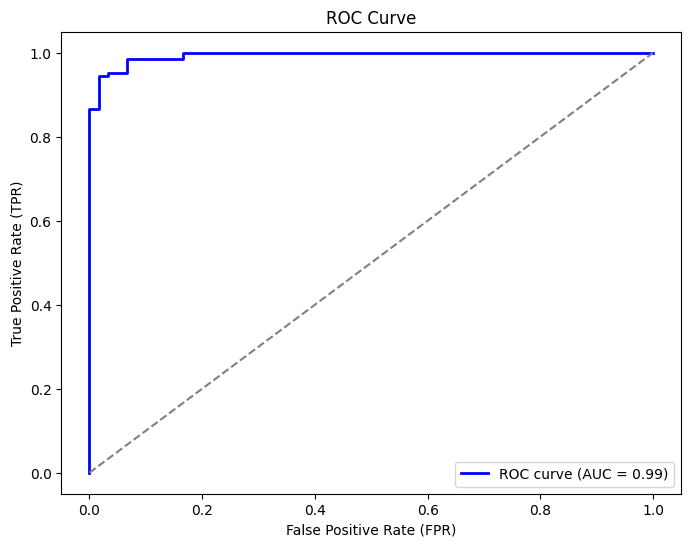

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have the true labels 'y_true' and predicted probabilities 'y_probs'
fpr, tpr, thresholds = roc_curve(y_test, mc_pred_proba_array[:, 1])
auc = roc_auc_score(y_test, mc_pred_proba_array[:, 1])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [35]:
y_train.shape

(186, 109, 91, 3)

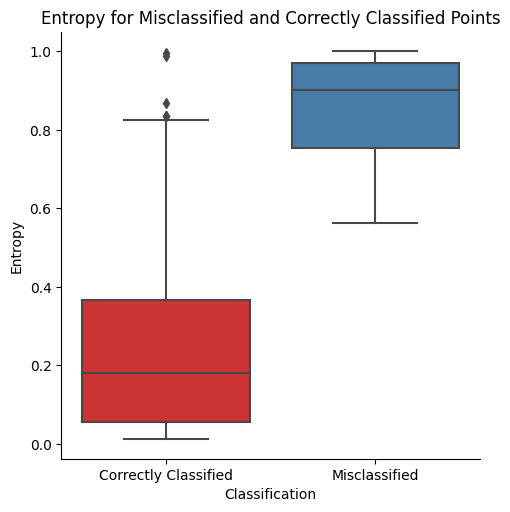

In [36]:

# Compare the predictions with the true values to find correctly classified and misclassified points
correctly_classified = y_pred == y_test
misclassified = y_pred != y_test

# Create a pandas DataFrame to organize the data for the plot
data_noclass = pd.DataFrame({
    'Classification': ['Correctly Classified' if x else 'Misclassified' for x in correctly_classified],
    'Entropy': entropy
})

# Create the catplot using seaborn
sns.catplot(x='Classification', y='Entropy', data=data_noclass, kind='box', palette='Set1')

# Set plot labels and title
plt.xlabel('Classification')
plt.ylabel('Entropy')
plt.title('Entropy for Misclassified and Correctly Classified Points')

# Show the plot
plt.show()

In [37]:
y_test_string = np.where(y_test, "PD", "HC")
data_pd = data_noclass.copy()
data_pd['Class'] = y_test_string

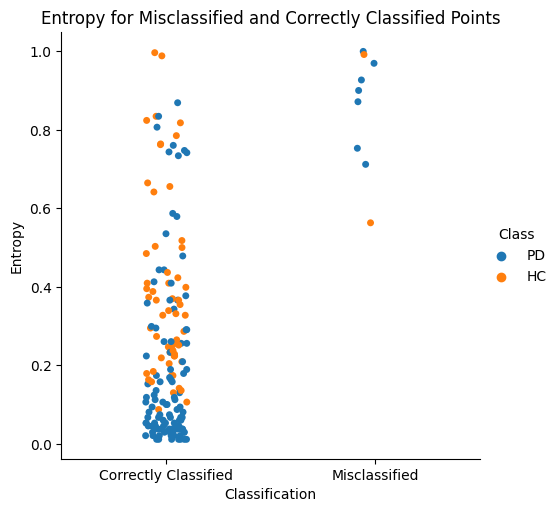

In [38]:

# Create the catplot using seaborn
sns.catplot(x='Classification', y='Entropy', data=data_pd, hue = 'Class')

# Set plot labels and title
plt.xlabel('Classification')
plt.ylabel('Entropy')
plt.title('Entropy for Misclassified and Correctly Classified Points')

# Show the plot
plt.show()

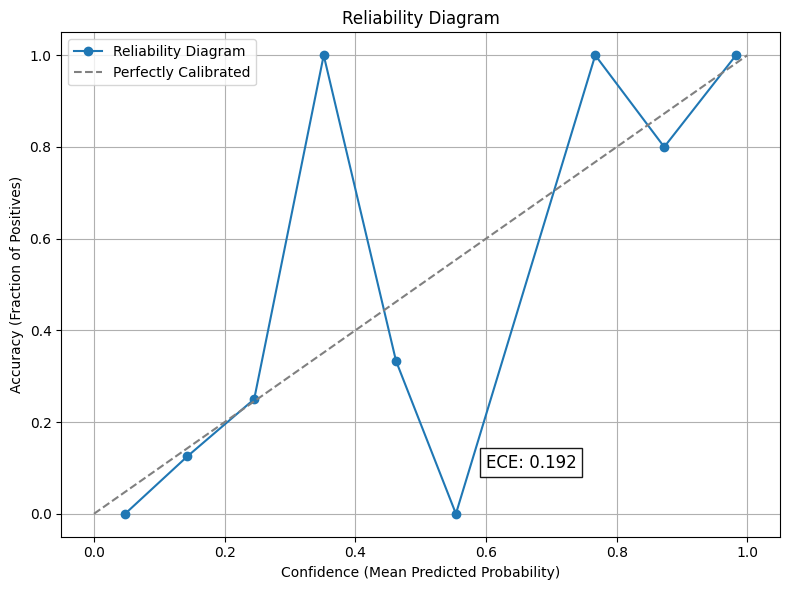

In [39]:
#DEEP ENSEMBLE RELIABILITY PLOT
from sklearn.calibration import calibration_curve
num_bins = 10

# Calculate reliability diagram data
prob_true, prob_pred = calibration_curve(y_test, mc_pred_proba_array[:, 1], n_bins=num_bins, strategy='uniform')

# Calculate the ECE
ece_confidence = np.mean(np.abs(prob_pred - prob_true))

# Plot the reliability diagram and ECE
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Reliability Diagram')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Confidence (Mean Predicted Probability)')
plt.ylabel('Accuracy (Fraction of Positives)')
plt.title('Reliability Diagram')
plt.legend()

# Display the ECE value in the plot
plt.text(0.6, 0.1, f'ECE: {ece_confidence:.3f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.9))

plt.grid(True)
plt.tight_layout()
plt.show()

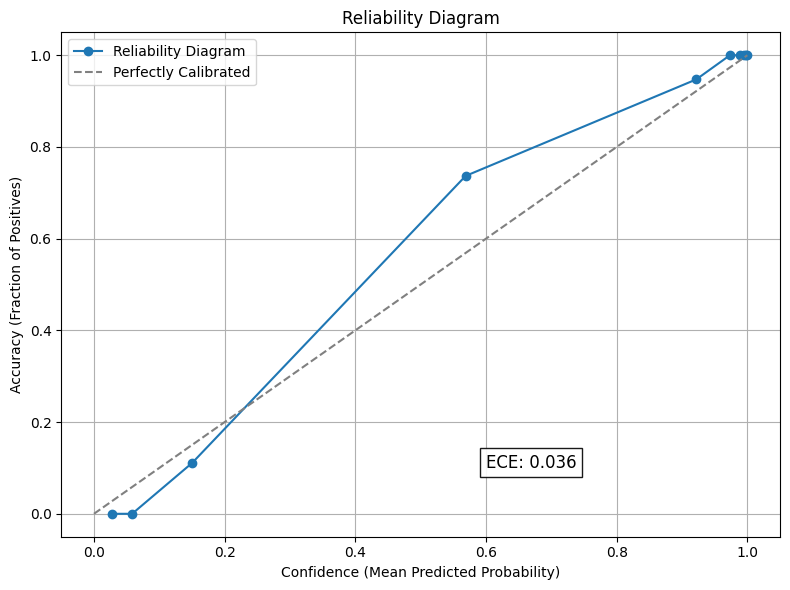

In [40]:
#DEEP ENSEMBLE RELIABILITY PLOT
from sklearn.calibration import calibration_curve
num_bins = 10

# Calculate reliability diagram data
prob_true, prob_pred = calibration_curve(y_test, mc_pred_proba_array[:, 1], n_bins=num_bins, strategy='quantile')

# Calculate the ECE
ece_confidence = np.mean(np.abs(prob_pred - prob_true))

# Plot the reliability diagram and ECE
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Reliability Diagram')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Confidence (Mean Predicted Probability)')
plt.ylabel('Accuracy (Fraction of Positives)')
plt.title('Reliability Diagram')
plt.legend()

# Display the ECE value in the plot
plt.text(0.6, 0.1, f'ECE: {ece_confidence:.3f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.9))

plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

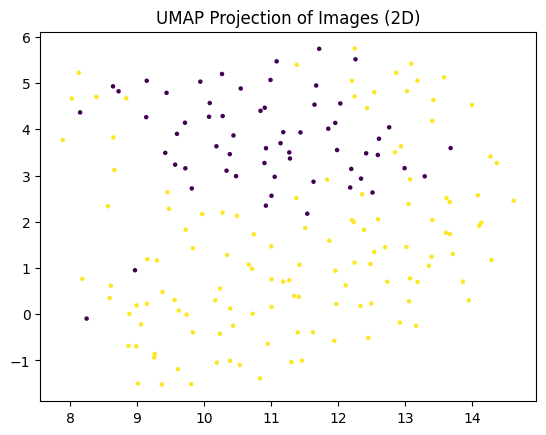

In [42]:
import umap.umap_ as umap 

# Create a UMAP model
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.6, n_components=2, random_state = 42)

# Fit and transform the data
umap_result = umap_model.fit_transform(X_std)

# Visualize the 2D points
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=y_test, cmap='viridis', s=5)
plt.title("UMAP Projection of Images (2D)")
plt.show()

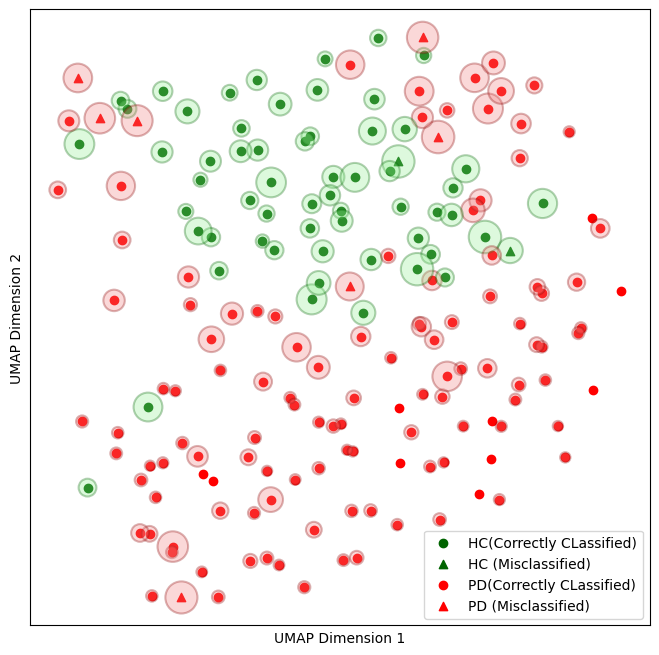

In [43]:
#BEST!!
x = umap_result[:, 0]
y = umap_result[:, 1]

fig, ax = plt.subplots(figsize=(8, 8))

for c in range(2):
    mask = y_test == c  # Use ground truth labels for class mask
    
    # Correctly classified points as circles
    if c == 1:
        correct_mask = (y_test == y_pred) & (y_test == 1)
        ax.scatter(x[correct_mask], y[correct_mask], marker='o', color='red', label='PD(Correctly CLassified)')
    else:
        correct_mask = (y_test == y_pred) & (y_test == 0)
        ax.scatter(x[correct_mask], y[correct_mask], marker='o', color='darkgreen', label='HC(Correctly CLassified)')
    
    # Misclassified points as triangles
    misclassified_mask = (y_test != y_pred) & (y_test == c)
    if c == 1:
        ax.scatter(x[misclassified_mask], y[misclassified_mask], marker='^', color='red', label='PD (Misclassified)')
    else:
        ax.scatter(x[misclassified_mask], y[misclassified_mask], marker='^', color='darkgreen', label='HC (Misclassified)')

# Add legend
ax.legend()

# Add uncertainty as size of markers
sizes = 50 + 500 * entropy  # Modify the sizes based on uncertainty
uncertainty_colors = np.where(y_test == 1,'lightcoral', 'lightgreen')
edge_colors = np.where(y_test == 1, 'darkred', 'darkgreen')  # Use 'darkgreen' and 'darkred' for edge colors
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')


ax.scatter(x, y, s=sizes, c=uncertainty_colors, alpha=transparency, edgecolor = edge_colors,  linewidths=1.5)
#Remove axes
ax.set_xticks([])
ax.set_yticks([])

plt.show()

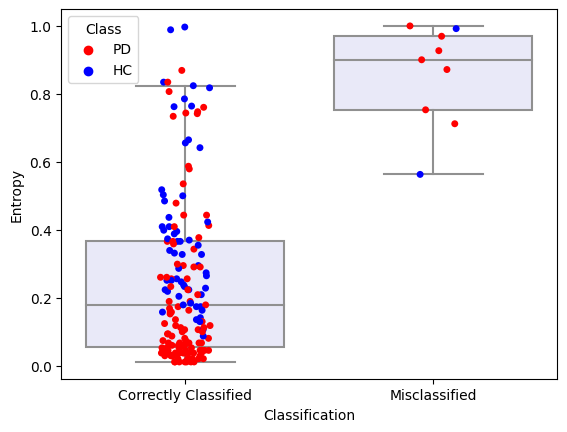

In [44]:
box_color_palette = ['#E6E6FA','#E6E6FA']# colors=[lavender, lavender]
strip_color_palette = {'HC': '#0000FF', 'PD': '#FF0000'}# colors=[bright red, bright blue]
fig, ax = plt.subplots()
ax = sns.boxplot(x='Classification', y='Entropy', data=data_noclass, palette=box_color_palette, showfliers=False)

sns.stripplot(x='Classification', y='Entropy', data=data_pd, hue = 'Class', ax=ax, palette=strip_color_palette)
plt.show()


In [45]:
# Step 1: Find Misclassified Point with Lowest Entropy
misclassified_points = data_pd[data_pd['Classification'] == 'Misclassified']
misclassified_points_sorted = misclassified_points.sort_values(by='Entropy', ascending=True)
lowest_entropy_misclassified = misclassified_points_sorted.iloc[0]

# Step 2: Use Lowest Entropy as Threshold
entropy_threshold = lowest_entropy_misclassified['Entropy']

# Step 3: Count Points Above Threshold
points_above_threshold = data_pd[data_pd['Entropy'] > entropy_threshold]

# Count Correctly Classified and Misclassified points above the threshold
correctly_classified_above_threshold = len(points_above_threshold[points_above_threshold['Classification'] == 'Correctly Classified'])
misclassified_above_threshold = len(points_above_threshold[points_above_threshold['Classification'] == 'Misclassified'])
total_above_threshold = correctly_classified_above_threshold + misclassified_above_threshold

# Display results
print(f"Lowest entropy misclassified point: {lowest_entropy_misclassified}")
print(f"Entropy threshold: {entropy_threshold}")
print(f"Number of Correctly Classified points above threshold: {correctly_classified_above_threshold}")
print(f"Number of Misclassified points above threshold: {misclassified_above_threshold}")
print(f"Total Number of samples above threshold: {total_above_threshold}")

Lowest entropy misclassified point: Classification    Misclassified
Entropy                0.562898
Class                        HC
Name: 49, dtype: object
Entropy threshold: 0.562897801399231
Number of Correctly Classified points above threshold: 21
Number of Misclassified points above threshold: 8
Total Number of samples above threshold: 29


In [46]:
# Step 1: Preprocess Data 1 = Correctly Classified, 0 = misclassified
data_pd["Entropy"] = data_pd["Entropy"].fillna(0)
data_pd['Label'] = (data_pd['Classification'] == 'Correctly Classified').astype(int)
classification_array = data_pd['Label'].values
entropy_array  = data_pd['Entropy'].values

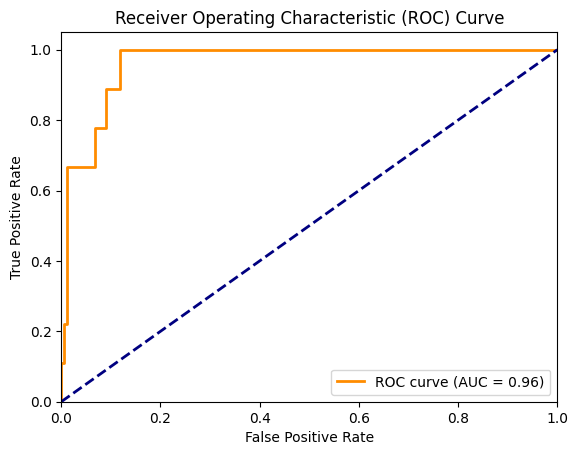

In [47]:
# Calculate true positive rate (sensitivity) and false positive rate for different thresholds
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(classification_array, entropy_array)
from sklearn.metrics import auc as sklearn_auc

# Calculate AUC
roc_auc = sklearn_auc(tpr, fpr)

# Plotting ROC curve
plt.figure()
plt.plot(tpr, fpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [48]:
data_pd

,Classification,Entropy,Class,Label
0,Correctly Classified,0.037622,PD,1
1,Correctly Classified,0.412663,PD,1
2,Correctly Classified,0.106274,PD,1
3,Correctly Classified,0.080793,PD,1
4,Correctly Classified,0.100082,PD,1
...,...,...,...,...
181,Correctly Classified,0.067222,PD,1
182,Correctly Classified,0.398646,HC,1
183,Correctly Classified,0.037622,PD,1
184,Correctly Classified,0.067222,PD,1


In [49]:
data_pd.to_csv('Model_entropy_data_csv/MCD_model.csv')